# Data analysis for Chapter "Global optima and fixed points"

This notebook ....

<https://debatelab.github.io/re-docs/rethon-docs/index-rethon.html>

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path
from ast import literal_eval
from statistics import mean

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

import seaborn as sns
sns.set_theme()

In [2]:
# Relevant dirs and file names

data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_mini'
data_file_name = f'{data_set_name}.tar.gz'
data_file_name = f'{data_set_name}.csv'

tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [3]:
# functions

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams["figure.figsize"] = (12,10)


    
    #exploded_fp_data.shape


## Loading data

In [4]:
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code',
           'weight_account', 'weight_systematicity', 
           'go_fixed_point', 'global_optima', 
           'fp_global_optimum', 'n_branches', 'n_fixed_points', 'n_global_optima',
           'fixed_point_is_global_optimum']
re_data = load_re_data(data_dir, data_file_name, usecols=usecols, filter_erroneous_runs=True)
#display(re_data.columns)

In [5]:
display(re_data.columns)

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'error_code', 'n_branches',
       'n_fixed_points', 'fixed_point_is_global_optimum', 'global_optima',
       'n_global_optima', 'go_fixed_point', 'fp_global_optimum',
       'model_short_name'],
      dtype='object')

## Data preparation

In [6]:
##### Adding some further cols
# Mean number of premises in tau
re_data['mean_n_premises'] = re_data.apply(lambda x: mean([len(arg)-1 for arg in literal_eval(x['ds'])]), axis=1)
# Adding bins for mean number of premises 
# Bins [1,1.25], ]1.25,1.5], ]1.5,1.75], ]1.75,2]
bins = {"1-1.25": (1,1.25),
        "1.25 - 1.5":(1.25,1.5),
        "1.5 - 1.75":(1.5,1.75),
        "1.75 - 2":(1.75,2)}

def get_bin_name(mean_n_premises):
    for key in bins.keys():
        min, max = bins[key]
        if mean_n_premises >=min and mean_n_premises<=max:
            return key

re_data['mean_n_premises_bin'] =  re_data.apply(lambda x: get_bin_name(x['mean_n_premises']) , axis=1)

In [7]:
re_data.tail()[['mean_n_premises','mean_n_premises_bin']]

,mean_n_premises,mean_n_premises_bin
349401,1.555556,1.5 - 1.75
349402,1.555556,1.5 - 1.75
349403,1.555556,1.5 - 1.75
349404,1.555556,1.5 - 1.75
349405,1.555556,1.5 - 1.75


In [8]:
# We need different views on the data.

#### 1. Result perspective on gos among fps 
# Idea: We collapse rows belonging to one simulation setup to one row and explode in column 'fp_global_optimum'
# collapse
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)
# explode
data_collapsed_fp_exploded = data_collapsed.explode('fp_global_optimum')

#### 2. Reachability of gos (share of gos that are reachable via RE processes)
# Idea: We collapse row of one simulation setup to one row and explode in column 'go_fixed_point'
# explode
data_collapsed_go_exploded = data_collapsed.explode('go_fixed_point')

## Clarifications

### Notation

Used terminlogy: 

+ An *ensemble* $E$ is the entirety of model runs by varying all specified parameter ranges.
    + Subscripts will denote certain subset within $E$ (e.g., $E_{M_1}$ might denote all models runs with the model $M_1$).
+ One ensemble run, or simulation $e\in E$ corresponds to one model run with a specified set of parameters (including all branches that might evolve in the process).
+ $B_e$ is the set of branches in $e$ and $b\in B_e$ denotes one specific branch in an ensemble run $e$.
+ $GO_e$ is the set of all global optima of an ensemble run.
+ $FP_e$ is the set of all fixed points (end points) of branches in $B_e$.
+ $FPGO$ (fixed-point global optima) is the set of fixed points in $e$ that are at the same time global optima ($GO_e \cap FP_e$).


## Model Overview

Here, we analyse the share of global optima among fixed points and the other way around.

We are interested in comparing different models of how the perform w.r.t. reaching global optima. 


Here we calculate

$$
\vert FPGO_m\vert/ \vert GO_m\vert := \frac{\sum_{e\in E_{m}}\vert FPGO_e\vert}{\sum_{e\in E}\vert GO_e\vert}
$$

as the overall share of fixped-point global optima among all global optima and

$$
\vert FPGO_m\vert/ \vert FP_m\vert := \frac{\sum_{e\in E_{m}}\vert FPGO_e\vert}{\sum_{e\in E}\vert FP_e\vert}
$$

as the overall share of fixped-point global optima among all fixied points for all model variations $m$.

### Table

In [9]:
bootstrap = True
n_resamples = 1000

### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df1 = rel_share_of_property(re_data, 
                                    property_col='fp_global_optimum',
                                    collapse_branches=True,
                                    col_rename=col_rename, 
                                    bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df1)

### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df2 = rel_share_of_property(re_data, 
                                    property_col='go_fixed_point',
                                    collapse_branches=True,
                                    col_rename=col_rename, 
                                    bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df2)

### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df3 = rel_share_of_property(re_data, 
                                   property_col= 'fixed_point_is_global_optimum',
                                   collapse_branches=False,
                                   col_rename=col_rename, 
                                   bootstrap=bootstrap, n_resamples=n_resamples)


result_df_result_perspective = pd.concat([result_df1, result_df2, result_df3], axis=1)
display(result_df_result_perspective)

# Changing col names for readability
cols_for_tables = {'model_short_name':'Model',
                   'rel_fpgo_go': 'Relative share of fixed points in global optima',
                   'rel_fpgo_fp_rp': 'Relative share of global optima in fixed points',
                   'rel_fpgo_fp_pp': 'Relative share of global optima in fixed points',
                  }
#display(result_df.rename(columns=cols_for_tables))
# Exporting relevant cols
result_df_result_perspective = result_df_result_perspective.reset_index()
result_df_result_perspective[['model_short_name','rel_fpgo_fp_rp','rel_fpgo_fp_pp','rel_fpgo_go']].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, 'table_go_fp.csv'), index=False)


,,rel_fpgo_fp_rp,std_fpgo_fp_rp,n_fpgo_rp,n_fixed_points,rel_fpgo_go,std_fpgo_go,n_global_optima,rel_fpgo_fp_pp,std_fpgo_fp_pp,n_fpgo_pp,n_branches
model_short_name,model_name,,,,,,,,,,,
LGRE,LinearGlobalRE,0.726019,0.002420,23385,32210,0.390071,0.001948,59949,0.726101,0.002461,23392,32218
LLRE,LinearLocalRE,0.449243,0.003354,10294,22907,0.172523,0.001507,59682,0.564365,0.001471,63191,111979
QGRE,QuadraticGlobalRE,0.742717,0.002139,30995,41725,0.483069,0.001965,64141,0.739760,0.002011,35584,48104
QLRE,QuadraticLocalRE,0.338440,0.002006,18833,55643,0.293917,0.001760,64071,0.344954,0.001223,54162,157018


### Venn Diagramms (result perspective)

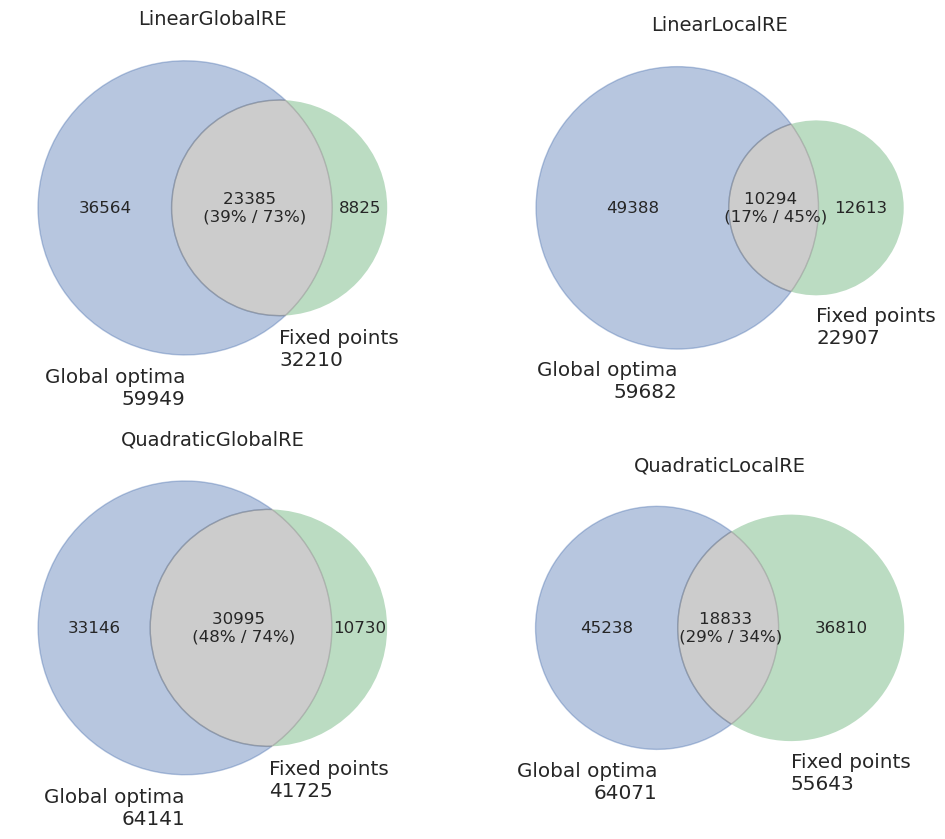

In [10]:
plot_venn(result_df_result_perspective, col_setA = "n_global_optima", col_setB = "n_fixed_points", 
          col_cut = "n_fpgo_rp", label_setA="Global optima", label_setB="Fixed points",
          output_dir=figures_output_dir, file_name='go-fp-venn')


## Dependence on sentence pool

### GO-Efficiency: GO among FP (result perspective)

In [11]:
bootstrap = True
n_resamples = 1000

### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df = rel_share_of_property(re_data, 
                                  property_col='fp_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  collapse_branches=True,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df.reset_index())

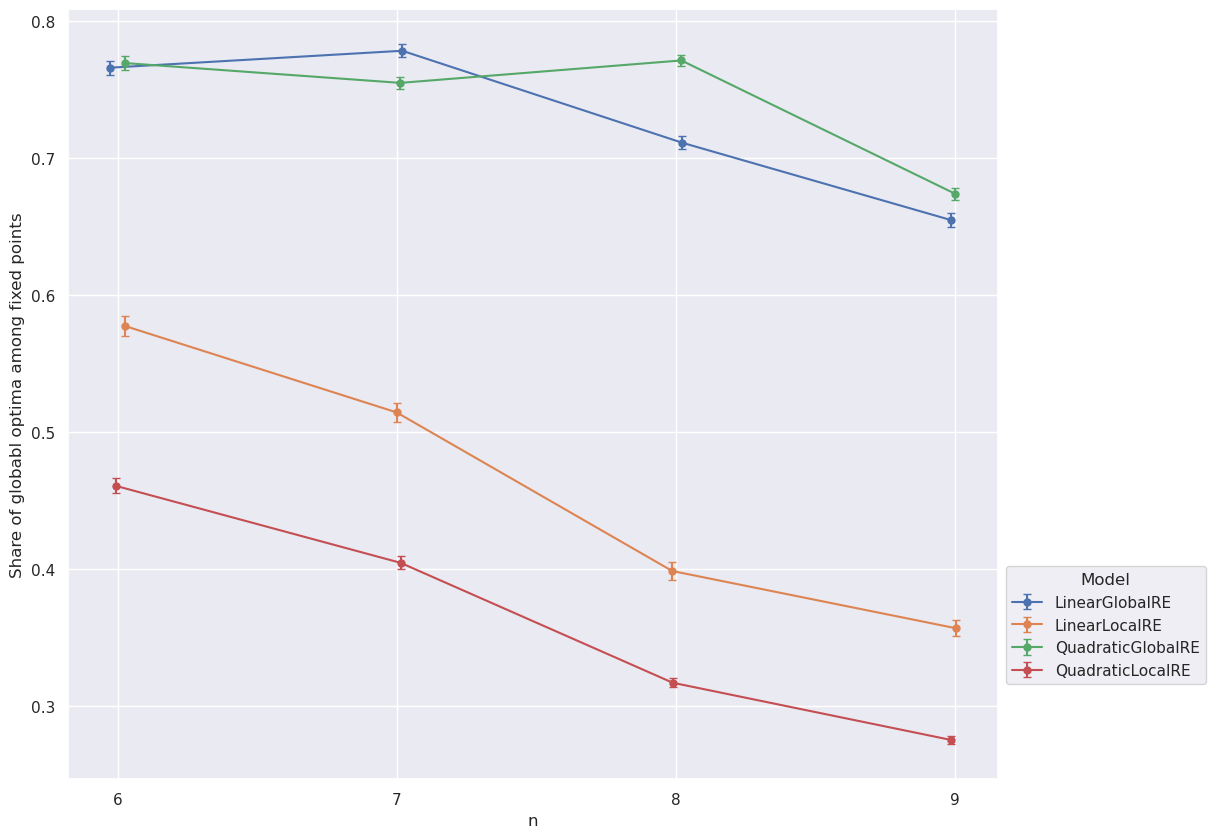

In [12]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_rp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_std = 'std_fpgo_fp_rp',
                         file_name='rel-fpgo-fp-by-n-rp', output_dir=figures_output_dir)

### GO-Efficiency: GO among FP (process perspective)

In [13]:
### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df = rel_share_of_property(re_data, 
                                  property_col= 'fixed_point_is_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  collapse_branches=False,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)

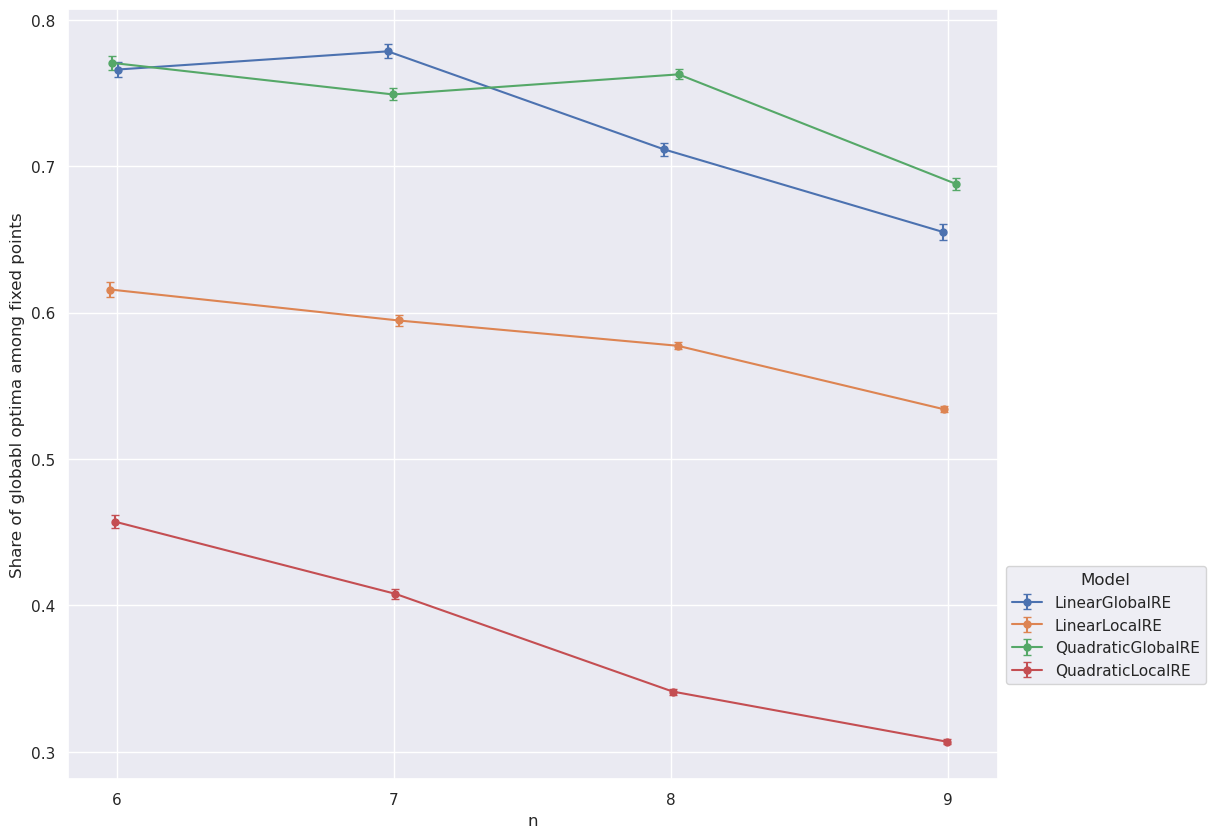

In [14]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_pp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_std = 'std_fpgo_fp_pp',
                         file_name='rel-fpgo-fp-by-n-pp', output_dir=figures_output_dir)

### GO-Reachability: FP among GO

In [15]:
### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df = rel_share_of_property(re_data, 
                                  property_col='go_fixed_point',
                                  collapse_branches=True,
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)


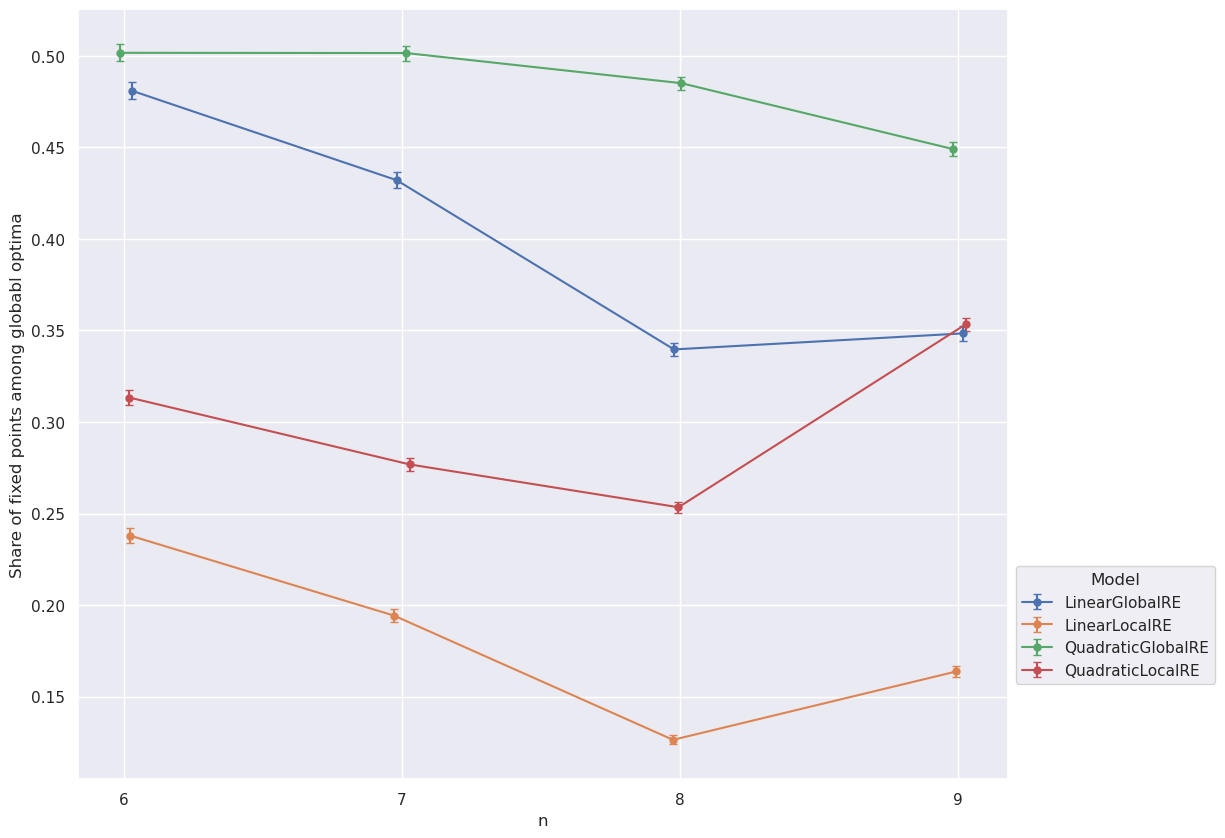

In [16]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_go', 
                         ylabel='Share of fixed points among globabl optima',
                         var_std = 'std_fpgo_go',
                         file_name='rel-fpgo-go-by-n', output_dir=figures_output_dir)

## Weight Dependence

### GO-Efficiency: GO among FP (result perspective)

#### Modelwise

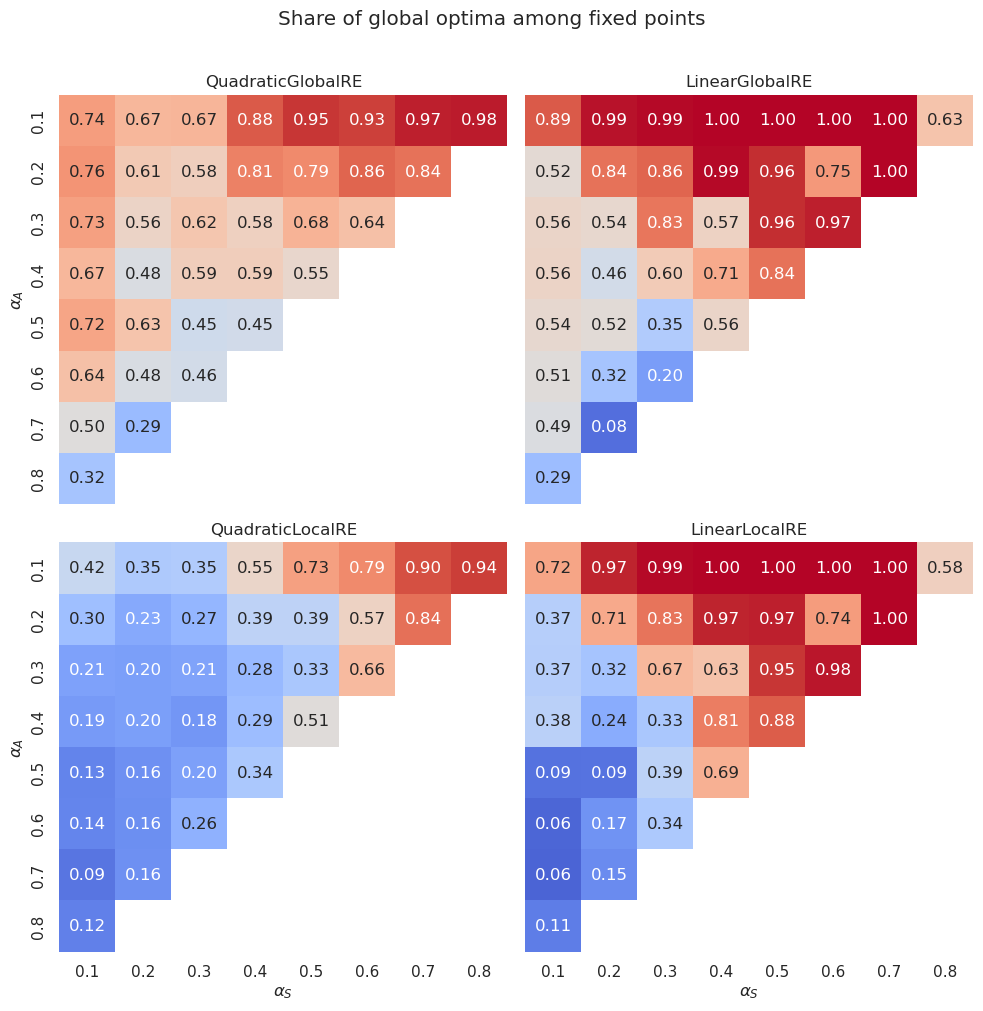

In [17]:
# Without bootstrapping
heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                     values ='fp_global_optimum', 
                     title = 'Share of global optima among fixed points', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-fp-rp', output_dir=figures_output_dir,
                     bootstrap=False)

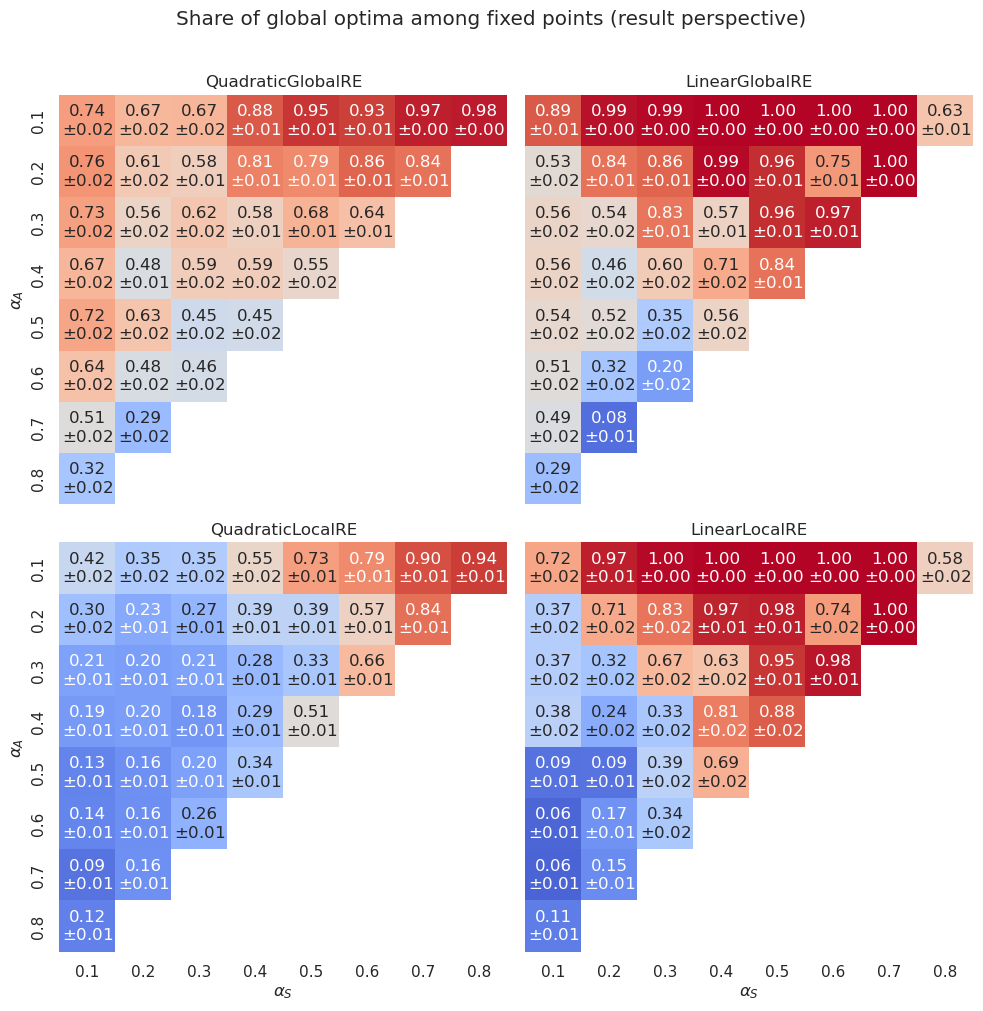

In [18]:
# With bootstrapping
heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                     values = 'fp_global_optimum', 
                     title = 'Share of global optima among fixed points (result perspective)', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = True, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-fp-rp', output_dir=figures_output_dir,
                     bootstrap=True)
    

#### Local vs. Global (go among fp)

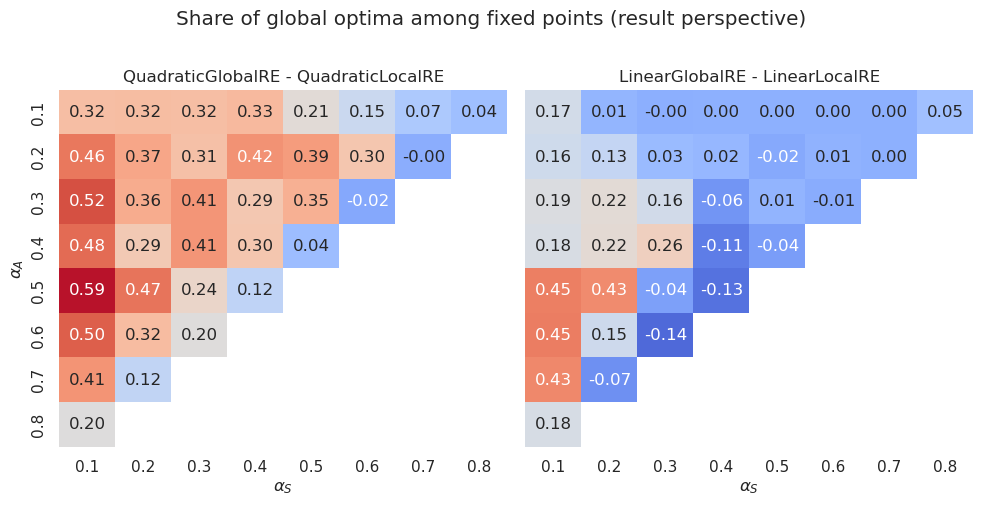

In [19]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                          values = 'fp_global_optimum',
                          title = 'Share of global optima among fixed points (result perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-fp-rp', output_dir=figures_output_dir,
                          bootstrap=False)


##### By mean number of premises

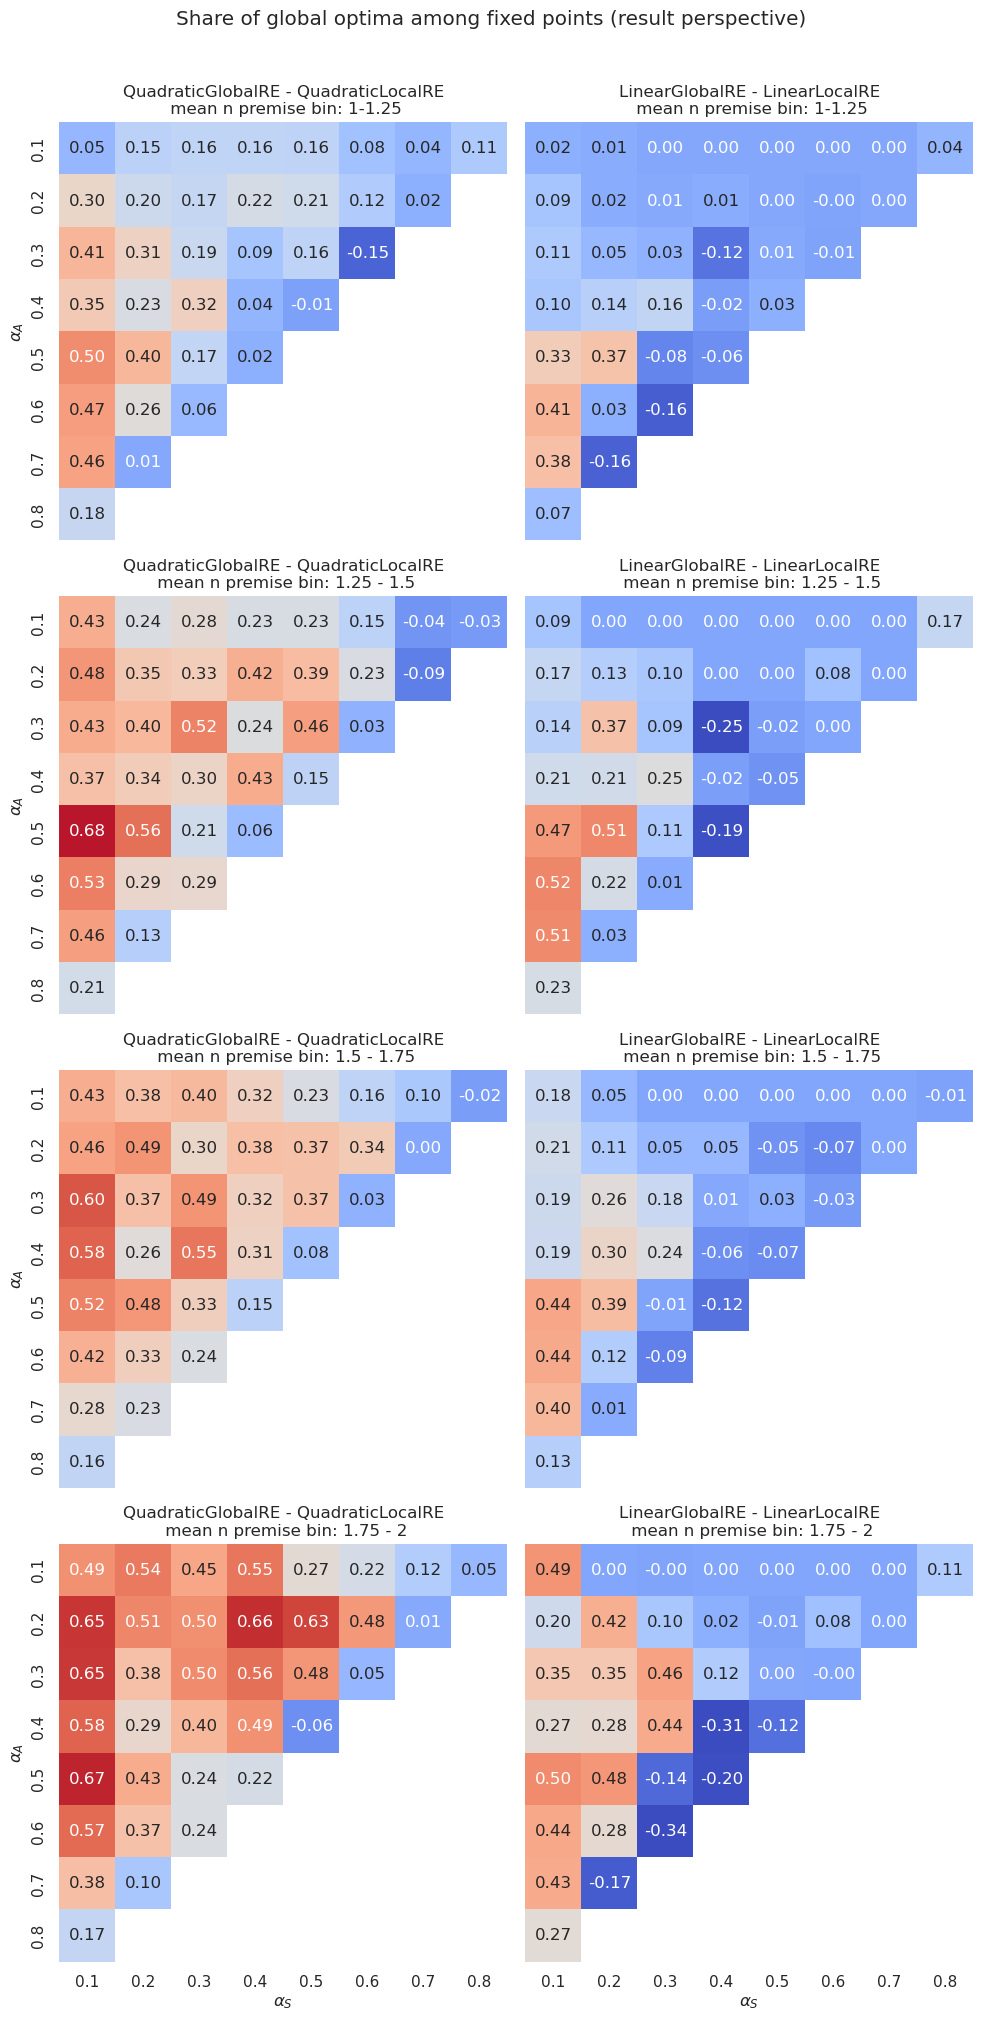

In [20]:
diff_heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                          values = 'fp_global_optimum',
                          row='mean_n_premises_bin',
                          title = 'Share of global optima among fixed points (result perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.7,
                          file_name='diff-hm-rel-fpgo-fp-by-n-premises-rp', output_dir=figures_output_dir,
                          bootstrap=False)


### GO-Efficiency: GO among FP (process perspective)

#### Modelwise

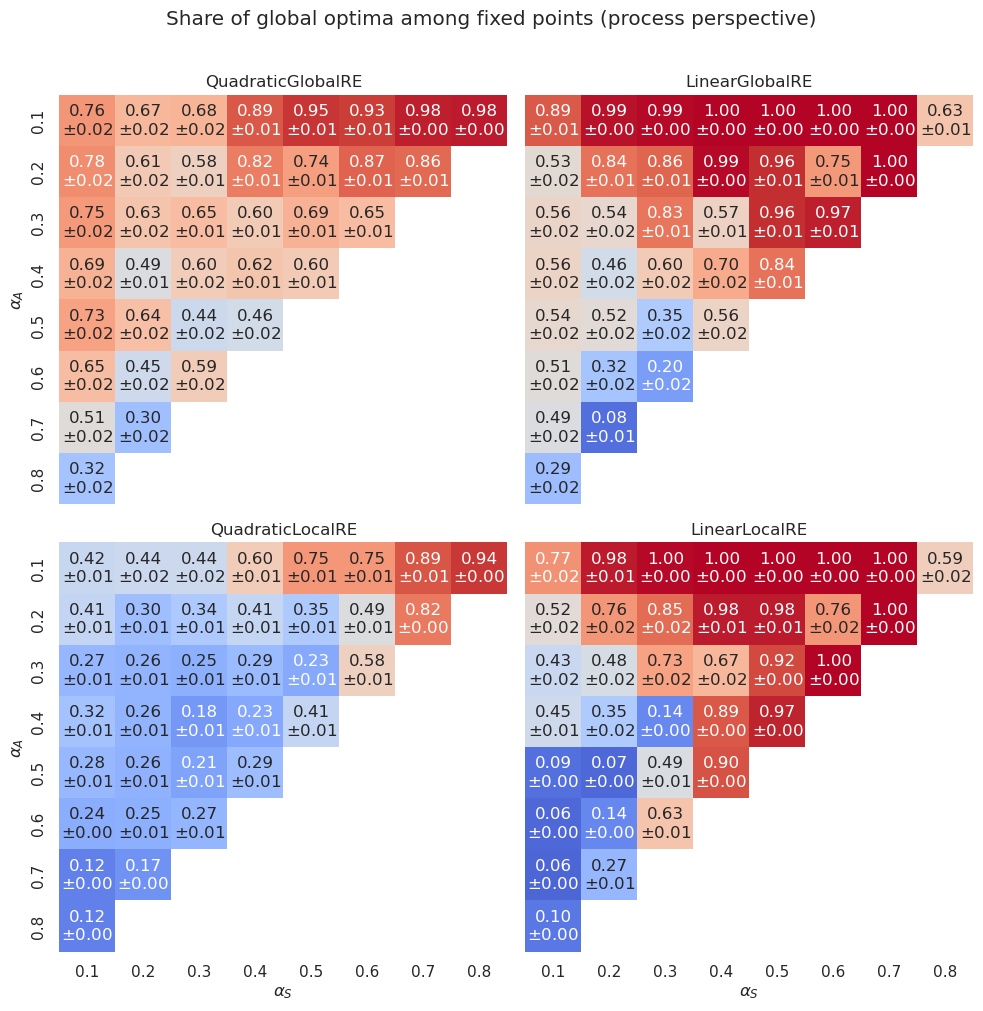

In [21]:
# With bootstrapping
heat_maps_by_weights(re_data = re_data, values = 'fixed_point_is_global_optimum', 
                    title = 'Share of global optima among fixed points (process perspective)', 
                    annot_fmt="{:2.2f}\n",
                    annot_std = True, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                    file_name='hm-rel-fpgo-fp-pp', output_dir=figures_output_dir,
                    bootstrap=True)
    

#### Local vs. Global (go among fp)

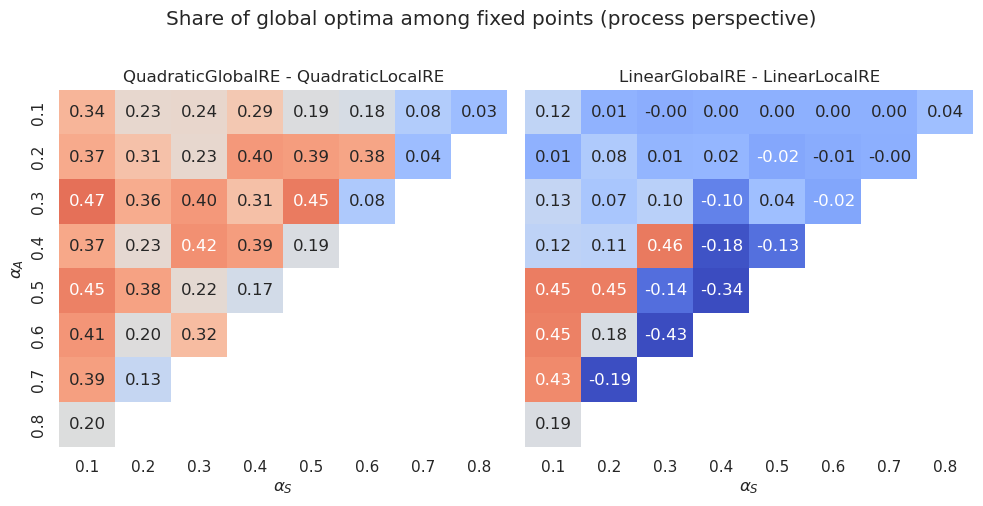

In [22]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = re_data, 
                          values = 'fixed_point_is_global_optimum',
                          title = 'Share of global optima among fixed points (process perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-fp-pp', output_dir=figures_output_dir,
                          bootstrap=False)


##### By mean number of premises

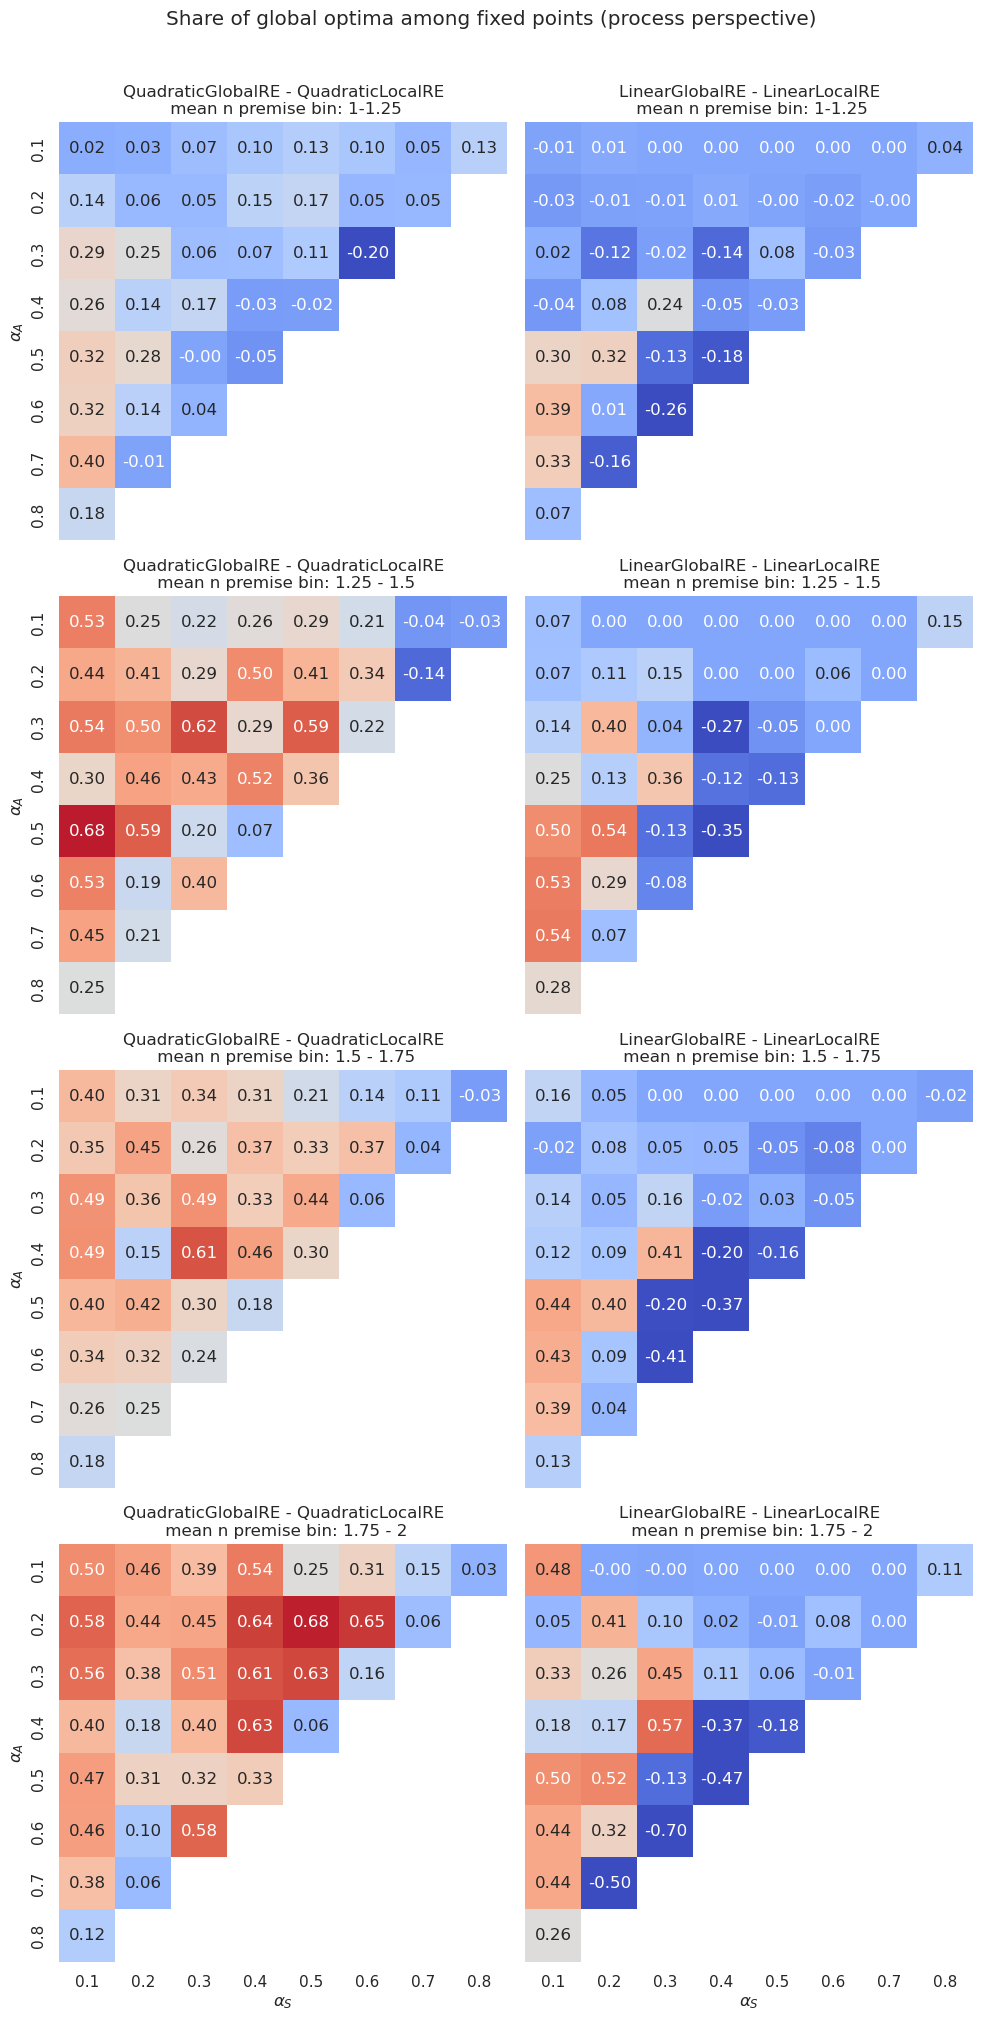

In [23]:
diff_heat_maps_by_weights(re_data = re_data, 
                          values = 'fixed_point_is_global_optimum',
                          row='mean_n_premises_bin',
                          title = 'Share of global optima among fixed points (process perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.7,
                          file_name='diff-hm-rel-fpgo-fp-by-n-premises-pp', output_dir=figures_output_dir,
                          bootstrap=False)


### GO-Reachability: FP among GO

#### Modelwise

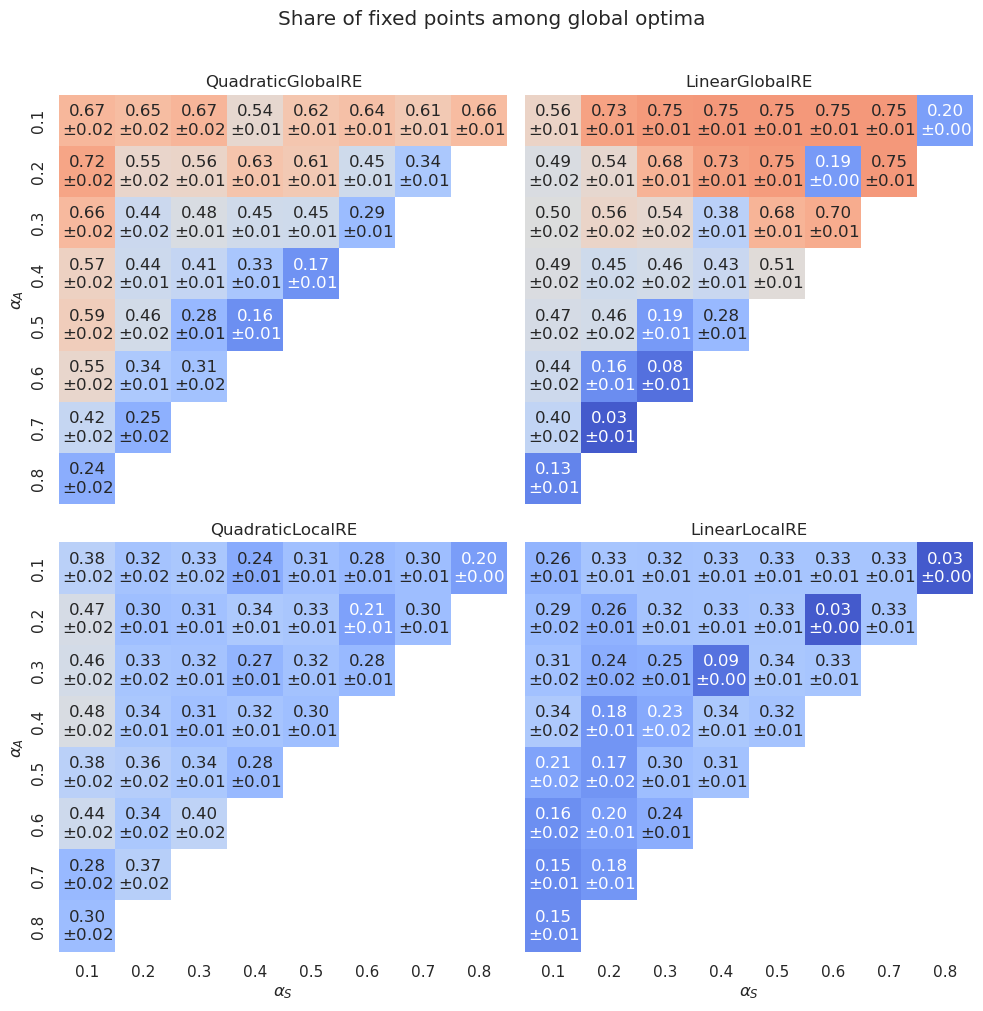

In [24]:
# With bootstrapping
heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                     values = 'go_fixed_point', 
                     title = 'Share of fixed points among global optima', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = True, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-go', output_dir=figures_output_dir,
                     bootstrap=True)
    

#### Local vs. Global (go among fp)

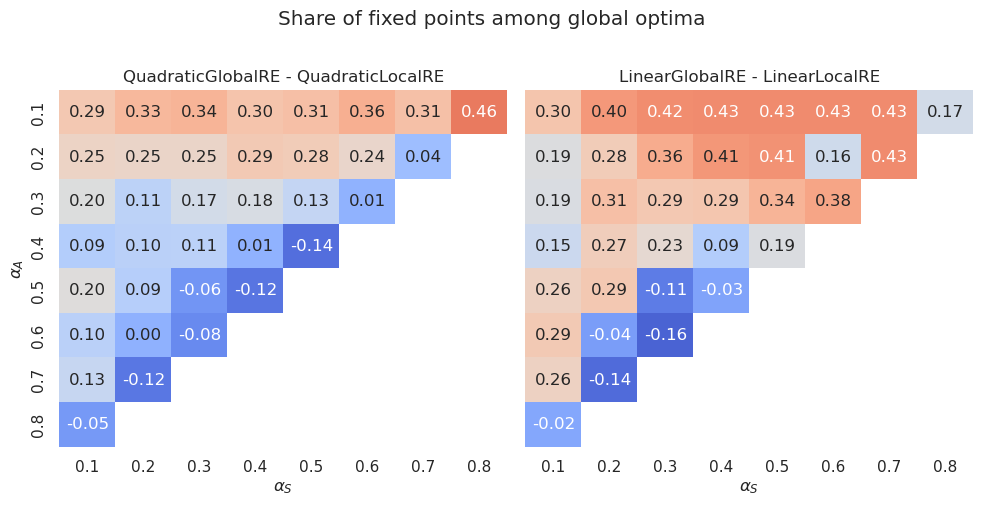

In [25]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                          values = 'go_fixed_point',
                          title = 'Share of fixed points among global optima', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-go', output_dir=figures_output_dir,
                          bootstrap=False)


##### By mean number of premises

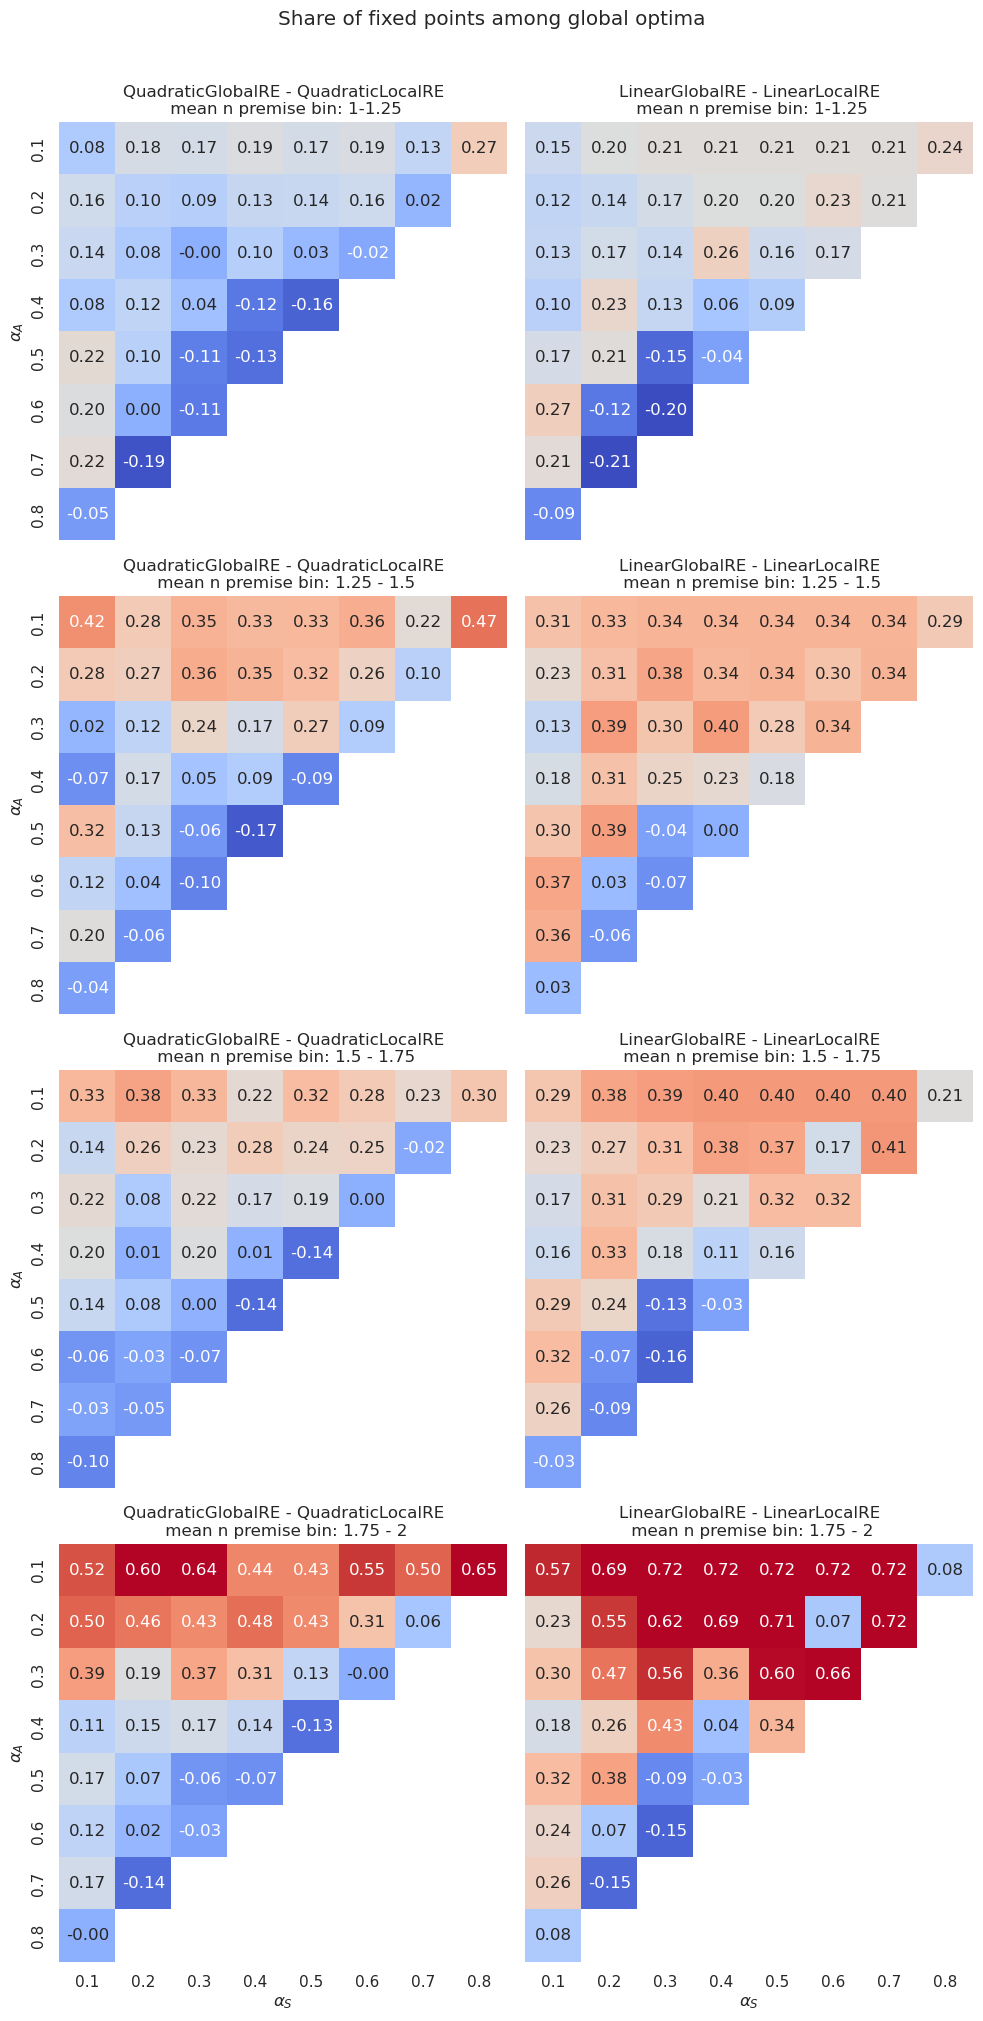

In [26]:
diff_heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                          values = 'go_fixed_point',
                          title = 'Share of fixed points among global optima', 
                          row='mean_n_premises_bin',
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-go-by-n-premises', output_dir=figures_output_dir,
                          bootstrap=False)


## Dependence on mean number of premises

### GO-Efficiency: GO among FP (result perspective)

In [27]:
bootstrap = True
n_resamples = 1000

### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df = rel_share_of_property(re_data, 
                                  property_col='fp_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  collapse_branches=True,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df.reset_index())

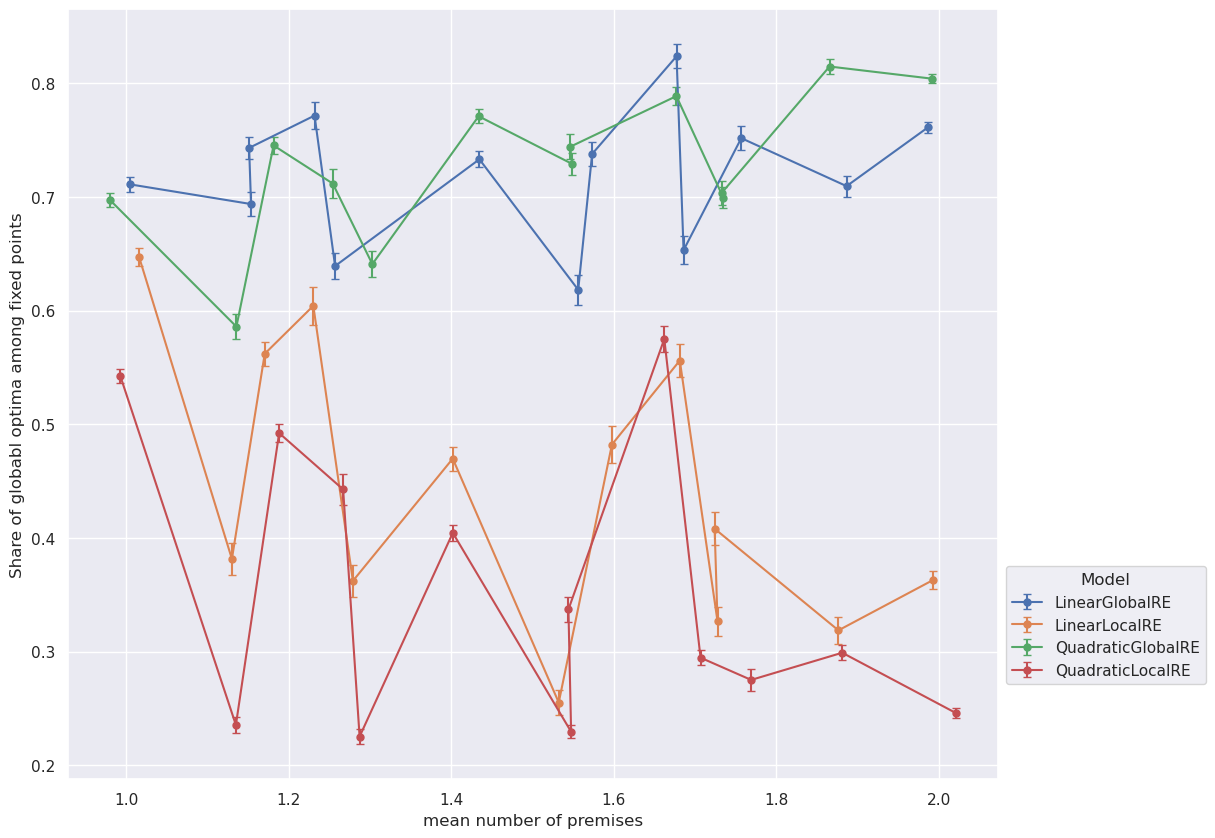

In [28]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_rp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_x = 'mean_n_premises', xlabel = 'mean number of premises', xticks=None,
                         var_std = 'std_fpgo_fp_rp',
                         file_name='rel-fpgo-fp-by-np-rp', output_dir=figures_output_dir)

### GO-Efficiency: GO among FP (process perspective)

In [29]:
### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df = rel_share_of_property(re_data, 
                                  property_col= 'fixed_point_is_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  collapse_branches=False,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)

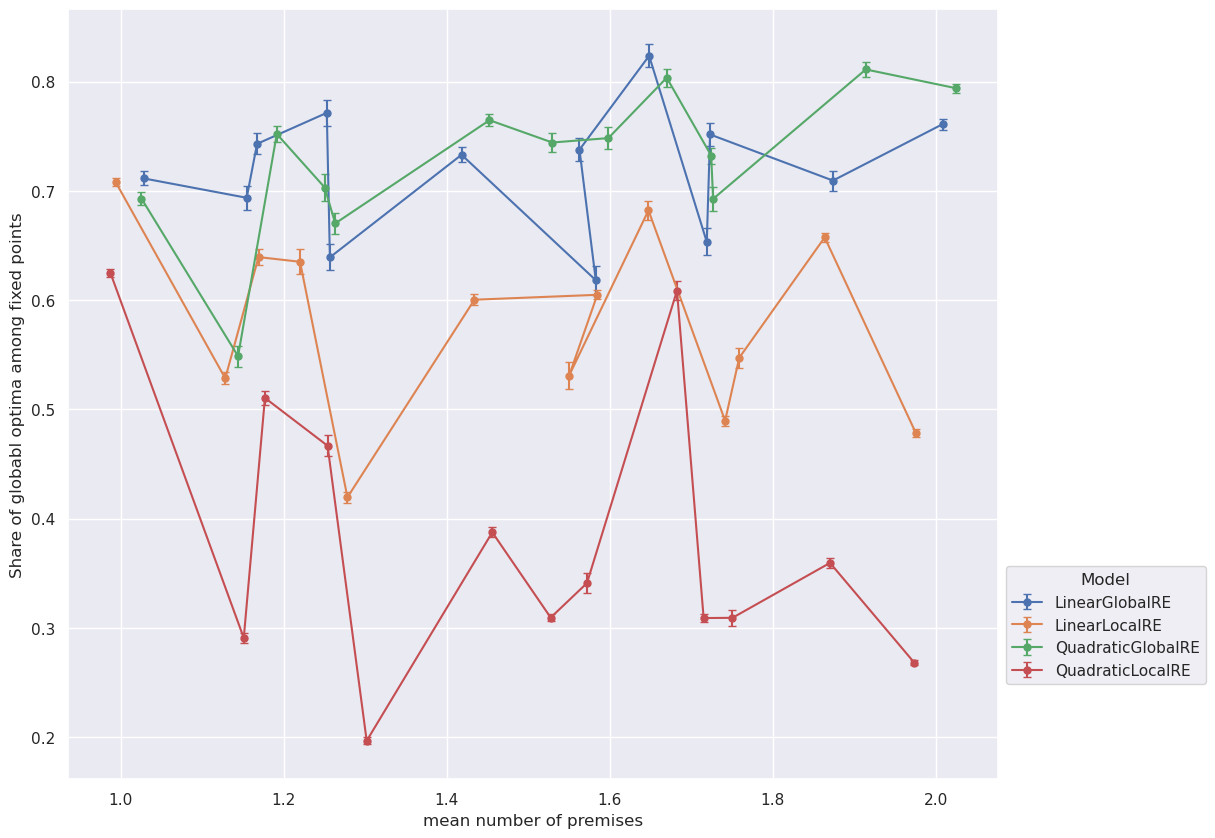

In [30]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_pp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_x = 'mean_n_premises', xlabel = 'mean number of premises', xticks=None,
                         var_std = 'std_fpgo_fp_pp',
                         file_name='rel-fpgo-fp-by-np-pp', output_dir=figures_output_dir)

### GO-Reachability: FP among GO

In [31]:
### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df = rel_share_of_property(re_data, 
                                  property_col='go_fixed_point',
                                  collapse_branches=True,
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)


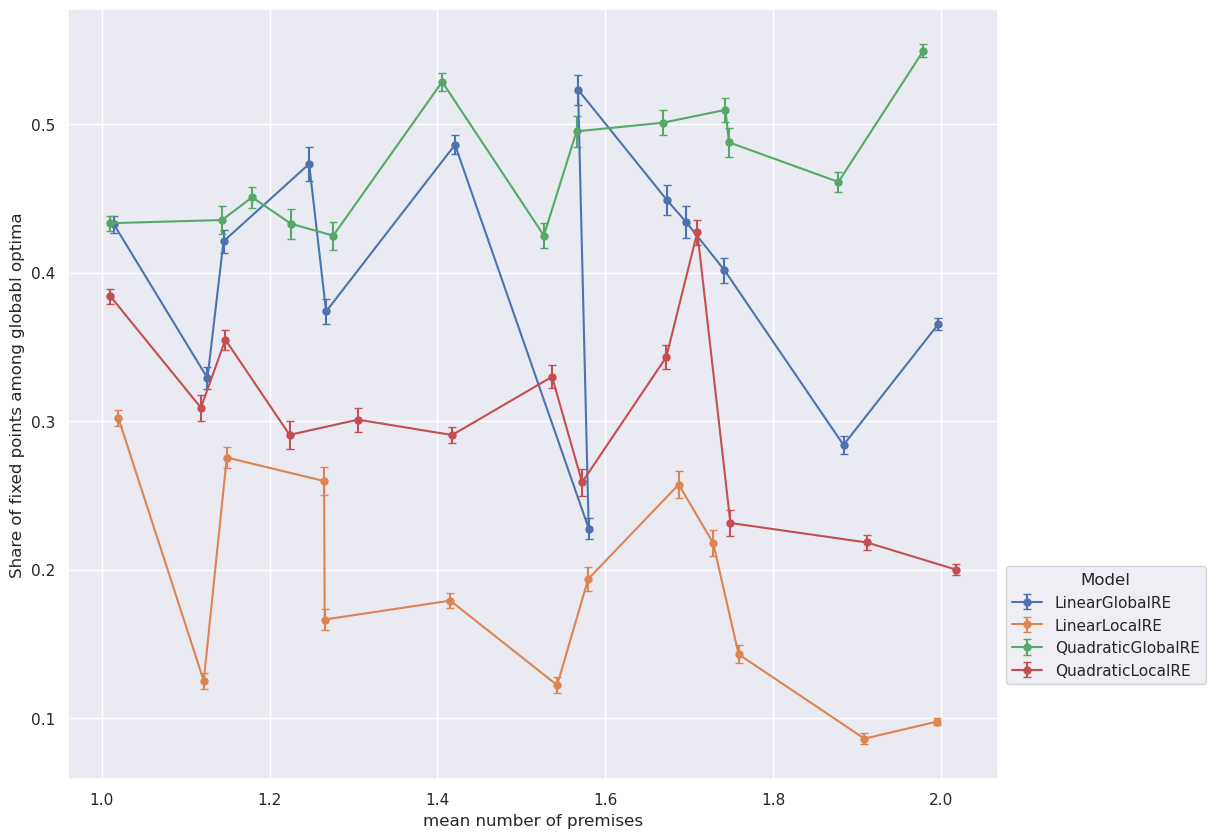

In [32]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_go', 
                         ylabel='Share of fixed points among globabl optima',
                         var_x = 'mean_n_premises', xlabel = 'mean number of premises', xticks=None,
                         var_std = 'std_fpgo_go',
                         file_name='rel-fpgo-go-by-np', output_dir=figures_output_dir)

## Deprecated (to be removed later on)

### Notes reduce, explode, ...

Properties of global optima/fixed point from the result and process perspective

Result and process perspective:

+ There is only a difference between the process and result perspective if we assess properties in relation to all fixed point w.r.t. simulation setups. The point is that different branches can lead to identical fixed point. What "all fixed point" encompasses depends, therefore, whether we consider the *set* of all fixed points (which can be smaller than the number of branches) or the fixed points of all branches, which might include fixed points more than once. We will refer to the former as the process perspective and to the latter as result perspective. 

Properties of **fixed points**: 

+ E.g., the share of fixed points that end up in global optima. 
+ *Result perspective*:
    + Interpretation:
    + Implementation 1:
        1. Reduce branches for each simulation setup to one row.
        2. Explode fixed points.
        3. Apply function to check property for every fixed point.
        4. Groupby and calculate means (relative share for binary variables) for subsets.
        5. Calculate variance by bootstrapping in every groupby-subset.
    + Implementation 2: If we already have the property as a list in every row (e.g., `fp_global_optimum`), we simply reduce and explode the property.
        1. Reduce branches for each simulation setup to one row.
        2. Explode list of properties for fixed points.
        4. Groupby and calculate means (relative share for binary variables) for subsets.
        5. Calculate variance by bootstrapping in every groupby-subset.

+ *Process perspective*: 
    + Interpretation: Roughly the "chance" to reach a global optimum. 
    + Implementation: 
        3. Apply function to check property for every fixed point.
        4. Groupby and calculate means (relative share for binary variables) for subsets.
        5. Calculate variance by bootstrapping in every groupby-subset.

Properties of **global optima**:

+ *Result perspective*:
    + Interpretation:
    + Implementation 1:
        1. Reduce branches for each simulation setup to one row.
        2. Explode global optima.
        3. Apply function to check property for every global optimum.
        4. Groupby and calculate means (relative share for binary variables) for subsets.
        5. Calculate variance by bootstrapping in every groupby-subset.
    + Implementation 2: see above


**Heat maps**: Concerns point (4) and is just another way of visualising the corresponding data. 

+ Implementation: So far, the bootstrapping is not implemented there. 

Comparing the performance of local and global models: E.g. relative share of go among fp (for different mean-premises bins and different alpha-weight combinations). 

+ Basic idea: we substract amount of fp that are go between the different models and divide by the number of rows in the respective subset.
    + Variance can again be calculated by bootstrapping.

### GO-Efficiency: GO among FP (result perspective) by mean number of premises (mean-mean)

In [33]:
re_data_collapsed_branches = re_data.drop_duplicates(cols_group_branches)


In [34]:
g = sns.lineplot(data=re_data_collapsed_branches, 
             x='mean_n_premises', 
             y='rel_fpgo_go', 
             hue='model_name',
             errorbar='sd')

ValueError: Could not interpret value `rel_fpgo_go` for parameter `y`

In [ ]:
g = sns.lineplot(data=re_data_collapsed_branches, 
             x='mean_n_premises', 
             y='rel_fpgo_fp', 
             hue='model_name',
             errorbar='sd')

### Table - Comp/Test (old code)

In [ ]:
# number of go that are fp for each model run (set redundantly in each branch)
re_data['n_fpgo'] = re_data.apply(lambda x: sum(x['go_fixed_point']) , axis=1)

# We want to summarise branches that belong to one ensemble run (i.e., to one set of initial coms, model name etc.)
# into one row.

# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 

re_data_collapsed_branches = re_data.drop_duplicates(cols_group_branches)
#display(re_data_collapsed_branches.head())

# aggregate values among models
agg_funs = {
    'n_branches': 'sum',
    'n_fixed_points': 'sum',
    'n_global_optima': 'sum',
    'n_fpgo': 'sum'
}

result_df = re_data_collapsed_branches.groupby(['model_short_name', 'model_name']).agg(agg_funs).reset_index()

# calcualte relative shares
# relative share of fixed point/reached gos among all global optima (in %)
result_df['rel_fpgo_go'] = result_df['n_fpgo']/result_df['n_global_optima']*100
# relative share of fixed point/reached gos among all fixed points (in %)
result_df['rel_fpgo_fp'] = result_df['n_fpgo']/result_df['n_fixed_points']*100

display(result_df)



### Mean-Mean Maps (old code: simulation-setup-wide mean)

For understanding the role of $\alpha$-weights for reaching global optima, we calculate for each ensemble $e$ the relative share of  fixed-point global optima ($\frac{\vert FPGO_e\vert}{\vert GO_e\vert}$ and $\frac{\vert FPGO_e\vert}{\vert FP_e\vert}$ respectively), and then aggregate over model model runs with the same $\alpha$-weight configuration. The heat map display means and standard deviations (to check) for each such configuartion. 

Note that these relative numbers mean sth. different than the aggregated relative numbers from above. In particular, the mean of these means aggregated of all weight configurations for a specific model are different from the above calculated numbers (TO CHECK).

For instance:
$$
\vert FPGO_m\vert/ \vert GO_m\vert \neq \frac{1}{\vert E_m \vert} \sum_{e\in E_m} \frac{\vert FPGO_e\vert}{\vert GO_e\vert}
$$

In [ ]:
# relative number of go that are fp among all global optima (in %)
re_data['rel_fpgo_go'] = re_data['n_fpgo']/re_data['n_global_optima']*100
# relative number of go that are fp among all fixed points (in %)
re_data['rel_fpgo_fp'] = re_data['n_fpgo']/re_data['n_fixed_points']*100
re_data_collapsed_branches = re_data.drop_duplicates(cols_group_branches)


In [ ]:
# here, we can see the difference in numbers (compare to the table from above)
result_df = re_data_collapsed_branches.groupby('model_name').agg({'rel_fpgo_go':'mean'}).reset_index()
display(result_df)

In [ ]:
# will give mean of relative shares for each simulation setup (over alpha-weights configurations)

normalized_heat_maps_by_weights(re_data = re_data_collapsed_branches, values = 'rel_fpgo_go', 
                                title = 'Mean number of fixed point global optima among global optima', 
                                annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=100,
                                file_name='hm-rel-fpgo-go', output_dir=figures_output_dir)